## Predicting Google stock Prices Using RNN
This use-case provides a demo of how RNN and GRU can be used to model time series data. In our use-case, we will use 'Google stock price' data to predict the number of future stock prices based on the available historical data. You have been given a dataset that contains google stock prices from 2013 to 2018. We have to model the time series data using RNN GRU sequential model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, SimpleRNN
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [2]:
# some functions to help out with predictions
def predictions_plot(test,predicted):
    plt.plot(test, color = 'red', label = 'Real Google stock price')
    plt.plot(predicted, color = 'blue', label = 'Predicted Google Stock Price')
    plt.title('Google Stock price Prediction')
    plt.xlabel('time')
    plt.ylabel('Google Stock Price')
    plt.legend()
    plt.show()
    
def rmse_return(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

## Collecting the Data
The dataset trainset.csv will be used for the demo. The dataset contains google stock prices from 2013 to 2018. It has been downloaded from the site https://www.kaggle.com/ptheru/google-stock-price-prediction-rnn/data 

In [3]:
# Load the data
dataset = pd.read_csv(r"C:\Users\Shivani Dussa\Downloads\trainset.csv", index_col = 'Date', parse_dates = ['Date'])
print(dataset.shape)
dataset.head()

(1259, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900


In [4]:
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-22,1061.109985,1064.199951,1059.439941,1060.119995,1060.119995,755100
2017-12-26,1058.069946,1060.119995,1050.199951,1056.739990,1056.739990,760600
2017-12-27,1057.390015,1058.369995,1048.050049,1049.369995,1049.369995,1271900
2017-12-28,1051.599976,1054.750000,1044.770020,1048.140015,1048.140015,837100
2017-12-29,1046.719971,1049.699951,1044.900024,1046.400024,1046.400024,887500


In [19]:
# Observation :
#The google stock price data is from 2013 to 2017

In [8]:
print(type(dataset))
print(type(dataset[:'2016']['High']))   #printing the type of data upto 2016 from 'high' column
print(type(dataset[:'2016']['High'].values))   # only values of High upto 2016 

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


#### Checking Nulls

In [39]:
dataset.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

#### Checking Duplicates

In [41]:
dataset.duplicated().sum()

0

In [10]:
dataset[:'2016']['High'].shape    # shape of high prediction upto 2016

(1008,)

In [12]:
dataset[:'2016']['High'].values

array([361.151062, 363.600128, 368.339294, ..., 794.22998 , 785.929993,
       782.780029])

In [13]:
x1 = dataset[:'2016']['High'].values
print(type(x1), x1.shape)


<class 'numpy.ndarray'> (1008,)


In [14]:
# reshaping 
x2 = x1.reshape(-1,1)
x2.shape

(1008, 1)

In [52]:
# training and testing data
training_set = dataset[:'2016']['High'].values.reshape(-1,1)
testing_set = dataset['2017':]['High'].values.reshape(-1,1)

print(training_set.shape,testing_set.shape,dataset.shape)
print(type(training_set),type(testing_set), type(dataset))

(1008, 1) (251, 1) (1259, 6)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>


In [ ]:
# we Have choosen High Attribute for Stock prices. Lets see how its look likes.

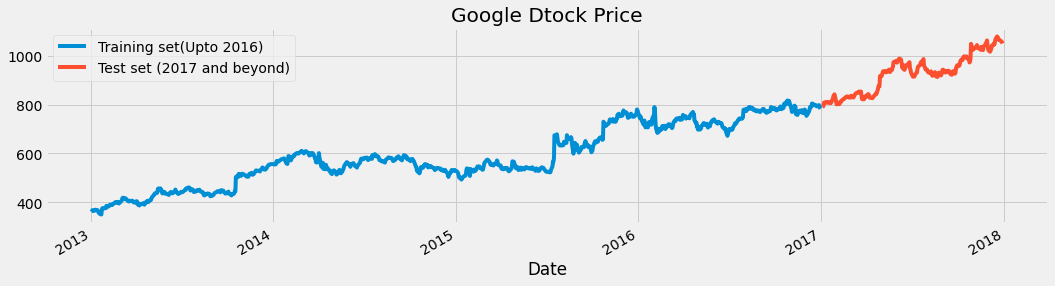

In [50]:
dataset['High'][:'2016'].plot(figsize = (16,4), legend = True)
dataset['High']['2017':].plot(figsize = (16,4), legend = True)
plt.legend(['Training set(Upto 2016)', 'Test set (2017 and beyond)'])
plt.title('Google Dtock Price')
plt.show()

In [51]:
training_set[:10]

array([[361.151062],
       [363.600128],
       [368.339294],
       [367.301056],
       [365.771027],
       [366.789398],
       [370.092896],
       [368.816193],
       [368.701935],
       [365.125214]])

In [53]:
# Scaling the training set
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled.shape

(1008, 1)

In [54]:
training_set_scaled

array([[0.02307584],
       [0.02832809],
       [0.03849167],
       ...,
       [0.95185386],
       [0.93405377],
       [0.92729837]])

In [57]:
# Before scaling (original)
training_set[:10]

array([[361.151062],
       [363.600128],
       [368.339294],
       [367.301056],
       [365.771027],
       [366.789398],
       [370.092896],
       [368.816193],
       [368.701935],
       [365.125214]])

In [58]:
# After scaling
training_set_scaled[:10]

array([[0.02307584],
       [0.02832809],
       [0.03849167],
       [0.03626508],
       [0.03298379],
       [0.03516778],
       [0.04225244],
       [0.03951443],
       [0.03926939],
       [0.03159878]])

- **We create a data Structure with 60 timesteps and 1 output**
- **One row of X_train will have 60 sequential values, and y_train will have the 61st value**

In [59]:
X_train = []
y_train = []
train_len = len(training_set_scaled)
for i in range(60, train_len):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train,y_train = np.array(X_train),np.array(y_train)
print(X_train.shape,y_train.shape)

(948, 60) (948,)


In [ ]:
# Here, 948 shape is 1008-60 = 948, and in X_train there are 60 timesteps and in y_train it have 61 st value 

In [62]:
X_train[0],

(array([0.02307584, 0.02832809, 0.03849167, 0.03626508, 0.03298379,
        0.03516778, 0.04225244, 0.03951443, 0.03926939, 0.03159878,
        0.02024195, 0.01523474, 0.00791565, 0.        , 0.04651394,
        0.05485572, 0.05661358, 0.05354532, 0.0549836 , 0.05924504,
        0.05569737, 0.07591806, 0.06938735, 0.07006918, 0.07204014,
        0.07827254, 0.08664632, 0.08273641, 0.08795672, 0.08524005,
        0.08885159, 0.0936671 , 0.10830522, 0.110404  , 0.10665391,
        0.10217937, 0.10980738, 0.09653293, 0.10590813, 0.10829455,
        0.10845438, 0.12518067, 0.14362215, 0.14772383, 0.13986139,
        0.13805026, 0.14314275, 0.13482224, 0.13354378, 0.12960193,
        0.1224746 , 0.11444173, 0.12135597, 0.11950222, 0.11887366,
        0.11708386, 0.1213347 , 0.1157628 , 0.10830522, 0.10656869]),)

In [63]:
y_train[0]

0.10324473039561122

For being used by the RNN/GRU/LSTM layers, we need the shape of X_train to be: [ batch_size, time_steps, Features ]
* We will use the full data in a single batch, so batch size will be 948
* There are 60 time steps
* At each time step, the price is the feature, which is of 1-dimension. Compare this with a word, which can have higher dimension based on the word embedding chosen

In [67]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
print(X_train.shape)

(948, 60, 1)


## Create the Model

* units - hidden layer dimension (no. of neurons)
* return sequences - when True, returns the output of each time step. Default False, returns the last output

In [68]:
model = Sequential()
model.add(SimpleRNN(50, input_shape = (X_train.shape[1],1), activation = 'tanh'))
model.add(Dropout(0.2))

# The output layer
model.add(Dense(units = 1))

In [69]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


## Train the Model

There aren't definitive results on one optimization algorithm being "better" than another. The common wisdom (which needs to be taken with a pound of salt) has been that Adam requires less experimentation to get convergence on the first try than SGD and variants thereof. However, this is highly dataset/model dependent. More recently some groups have made the claim that despite training faster, models trained with Adam generalize worse to the validation or test sets. See https://arxiv.org/abs/1712.07628 for more information.

Gradient descent optimization algorithms - nice blog - https://ruder.io/optimizing-gradient-descent/

In [70]:
# Compiling the GRU 
model.compile(optimizer = 'Adam',loss = 'mean_squared_error')
# Fitting the training set
model.fit(X_train, y_train, epochs = 50,batch_size = 150)

Epoch 1/50
7/7 [==============================] - 2s 19ms/step - loss: 0.0450
Epoch 2/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0201
Epoch 3/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0158
Epoch 4/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0123
Epoch 5/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0088
Epoch 6/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0077
Epoch 7/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0072
Epoch 8/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0070
Epoch 9/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0055
Epoch 10/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0053
Epoch 11/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0053
Epoch 12/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0052
Epoch 13/50
7/7 [==============================] - 0s 19ms/st

### Test the Model

* We use the previous 60 days’ stock prices to predict the next-day price
* So, we need the 60 days’ price before the 1st date in the test dataset.
* Accordingly, we create the input for prediction, index starting from the date 60 days before the first date in the test dataset.

In [77]:
dataset_total = dataset['High']   # total from 2013 to 2017
inputs = dataset_total[len(dataset_total) - len(testing_set) - 60:].values   # 60 values of traindata and all values of testdata
print(len(dataset_total), len(testing_set))
print(inputs.shape)

inputs = inputs.reshape(-1,1)
print(inputs.shape)
inputs = sc.transform(inputs)


1259 251
(311,)
(311, 1)


In [78]:
#inputs

In [81]:
# Preparing for X_test and predicting the prices
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
print(X_test.shape)

X_test = np.expand_dims(X_test, 2)
print(X_test.shape)

(251, 60)
(251, 60, 1)


In [83]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

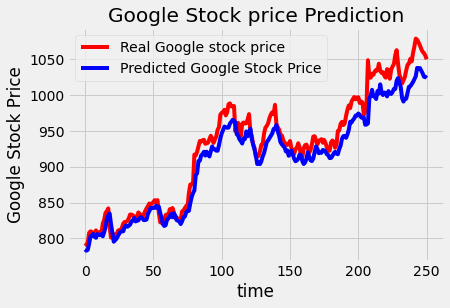

In [85]:
# Visualize the results for GPU 
predictions_plot(testing_set,predicted_stock_price) 

- **The prediction is almost almost same from 0 - 80  and at 180 - 250 there is much difference**

In [86]:
## Evaluating GRU 
rmse_return(testing_set, predicted_stock_price)

The root mean squared error is 21.361576889918414.
